In [1]:
from imp import reload
import utils as ul
from mlr import Model as md
import fw
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Data generation

In [22]:
## X: n*p  W: p*m  Y: n*m
np.random.seed(0)
n = 1000
m = 10
p = 100
r = 10
nn = 1
X, Y, W = md.generate(n, m, p, r, nn)

In [23]:
points = ul.mat2point(X,Y)
dataRDD = sc.parallelize(points).mapPartitions(ul.point2mat)
dataRDD = dataRDD.map(fw.row_data).setName("dataRDD").cache()
dataRDD.count()

8

## Loss vs. Epoch

In [55]:
T = 30                        # number of iterations of FW
loss = np.zeros((8, T + 1))
miss = np.zeros((8, T + 1))

In [56]:
# experiement parameter
np.random.seed(0)             
v0 = np.random.randn(m)

LMO = {0: fw.centralize, 
       1: fw.avgmix,
       2: lambda x, t=0: fw.poweriter(x, lambda t: 1, v0),
       3: lambda x, t=0: fw.poweriter(x, lambda t: 2, v0),
       4: lambda x, t=0: fw.poweriter(x, lambda t: 1),
       5: lambda x, t=0: fw.poweriter(x, lambda t: 2),
       #6: lambda x, t: fw.poweriter(x, fw.loground, v0, t),
       #7: lambda x: fw.poweriter(x, fw.loground)
      }

In [57]:
for i, lmo in LMO.items():
    # initialization
    loss[i, 0] = md.loss(X, Y, np.zeros(W.shape))
    miss[i, 0] = md.miss(X, Y, np.zeros(W.shape))
    rdd = dataRDD.map(fw.row_param)
    np.random.seed(0)
    
    # iteration
    for t in range(T):
        rdd, _, _, loss[i, t+1], miss[i, t+1]= fw.iterate(rdd, md, lmo, fw.naivestep, 20, t)
        
    loss[i, :] /= loss[i, 0]    
    miss[i, :] /= n

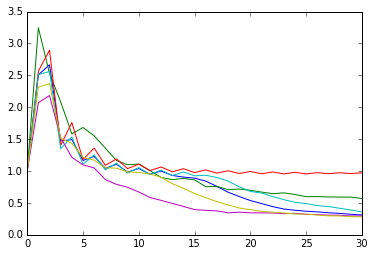

In [58]:
plt.plot(loss.T)

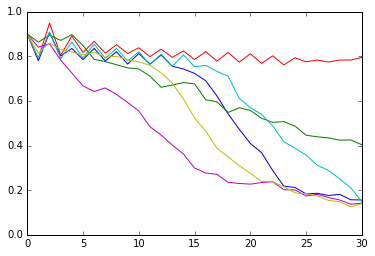

In [59]:
plt.plot(miss.T)

## Loss vs. Time

In [60]:
elapsed = np.zeros((8, T + 1))

In [61]:
for i, lmo in LMO.items():
    # initialization
    rdd = dataRDD.map(fw.row_param)
    np.random.seed(0)
    
    # iteration
    elapsed[i, 0] = time.time()
    for t in range(T):
        rdd, _, _, _, _ = fw.iterate(rdd, md, lmo, fw.naivestep, 20, t, False, False)
        elapsed[i, t + 1] = time.time()
        
    elapsed[i, :] -= elapsed[i, 0]

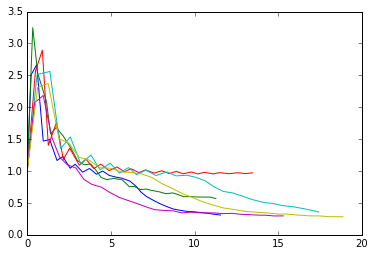

In [65]:
plt.plot(elapsed.T, loss.T)

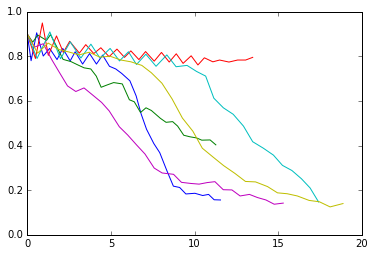

In [66]:
plt.plot(elapsed.T, miss.T)